# Form Field Extraction

Business documents like invoices, forms, and applications contain field-value pairs that need to be extracted. This tutorial shows how to identify and extract these form fields.

In [1]:
#%pip install "natural-pdf[all]"

In [2]:
from natural_pdf import PDF

# Load a PDF
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")
page = pdf.pages[0]

# Find fields with labels ending in colon
labels = page.find_all('text:contains(":")')

# Visualize the found labels
labels.show(color="blue", label="Field Labels")

# Count how many potential fields we found
len(labels)

CropBox missing from /Page, defaulting to MediaBox


4

## Extracting Field Values

In [3]:
# Extract the value for each field label
form_data = {}

for label in labels:
    # Clean up the label text
    field_name = label.text.strip().rstrip(':')
    
    # Find the value to the right of the label
    value_region = label.right(width=200)
    value = value_region.extract_text().strip()
    
    # Store in our dictionary
    form_data[field_name] = value

# Display the extracted data
form_data

{'Site': 'Durham’s Meatpacking Chicago, Ill.\nFebruary 3, 1905\ntion Count: 7\nmary: Worst of any, however, were the fertilize\ne people could not be shown to the visitor - for\nr at a hundred yards, and as for the other men\nof which there were open vats near the level\nhe vats; and when they were fished out, there\niting - sometimes they would be overlooked fo\nworld as Durham’s Pure Leaf Lard!\nations\nute Description\n.7 Unsanitary Working Conditions.\n3 Inadequate Protective Equipment.\n9 Ineffective Injury Prevention.\n5 Failure to Properly Store Hazardous M\n2 Lack of Adequate Fire Safety Measure\n4 Inadequate Ventilation Systems.\n.7 Insufficient Employee Training for Safe\nJungle Healt',
 'Date': 'Durham’s Meatpacking Chicago, Ill.\nFebruary 3, 1905\non Count: 7\nary: Worst of any, however, were the fertilizer\npeople could not be shown to the visitor - for t\nat a hundred yards, and as for the other men,\nof which there were open vats near the level o\ne vats; and when they w

## Visualizing Labels and Values

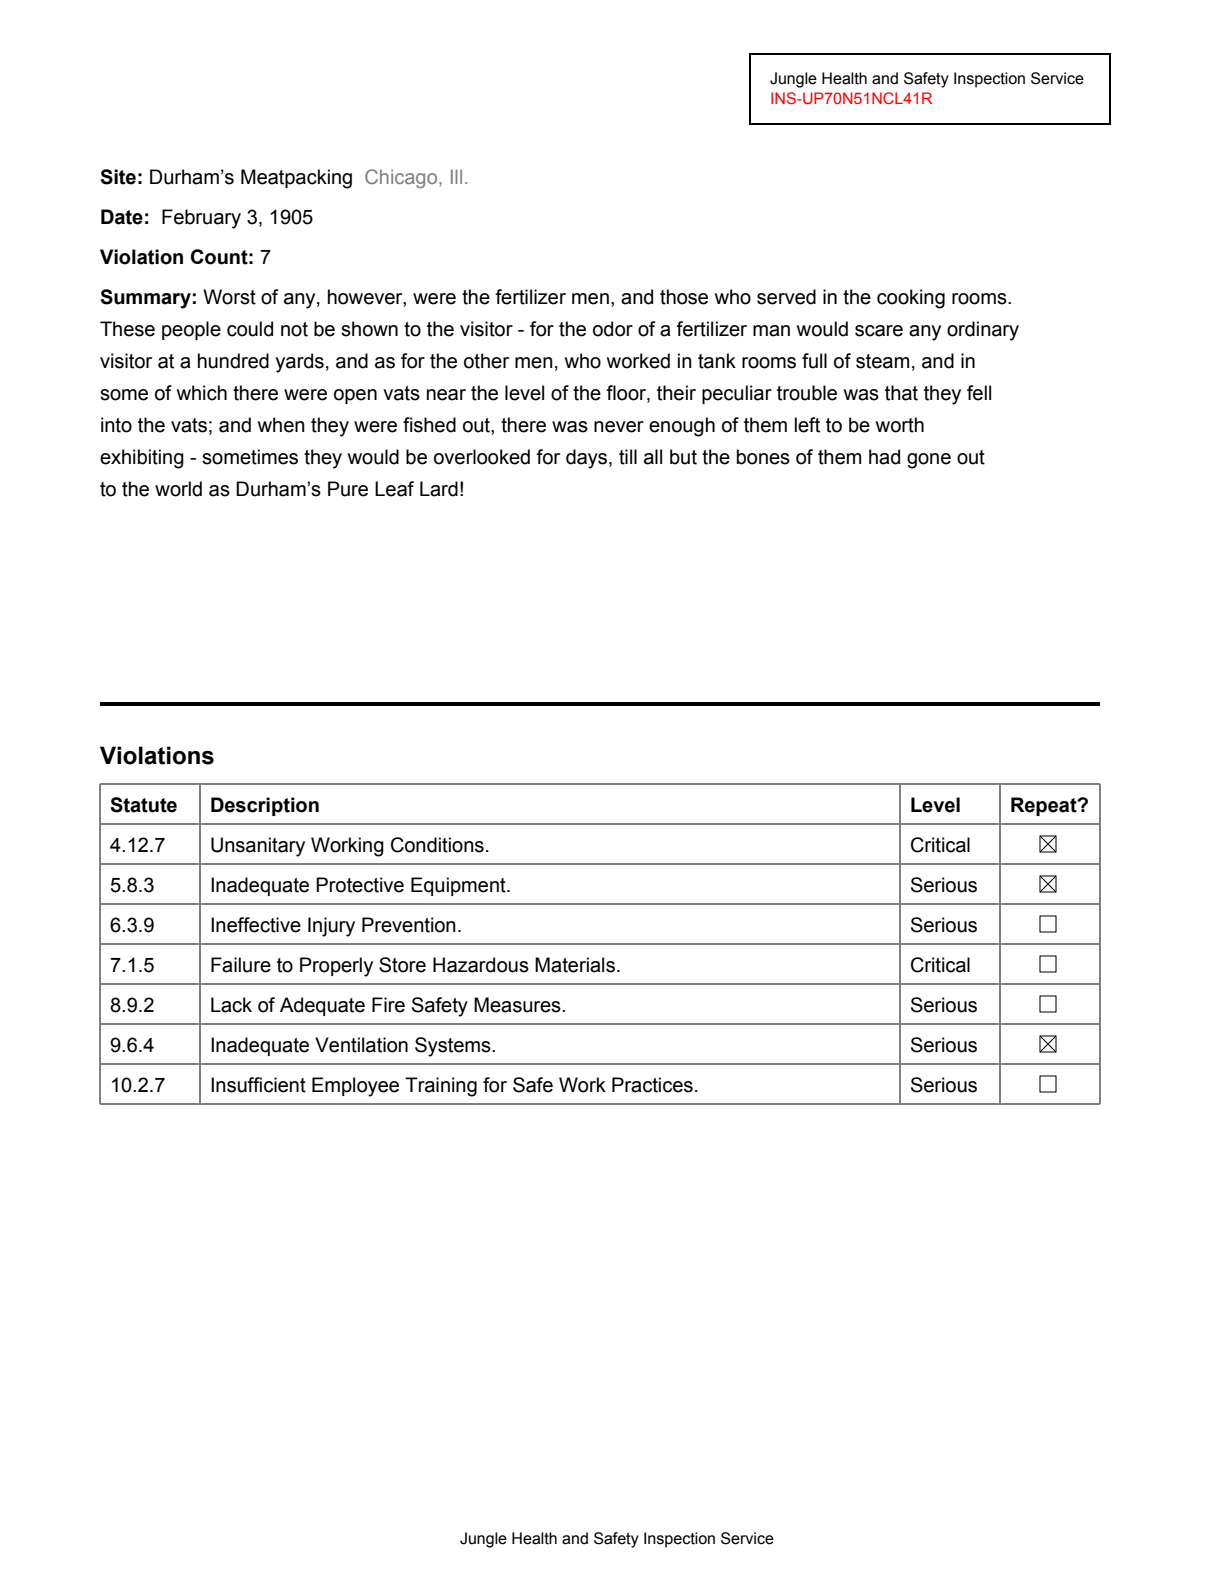

In [4]:
# Clear previous highlights
page.clear_highlights()

# Highlight both labels and their values
for label in labels:
    # Highlight the label in red
    label.show(color="red", label="Label")
    
    # Highlight the value area in blue
    label.right(width=200).show(color="blue", label="Value")

# Show the page image with highlighted elements
page.to_image()

## Handling Multi-line Values

In [5]:
# Extract values that might span multiple lines
multi_line_data = {}

for label in labels:
    # Get the field name
    field_name = label.text.strip().rstrip(':')
    
    # Look both to the right and below
    right_value = label.right(width=200).extract_text().strip()
    below_value = label.below(height=50).extract_text().strip()
    
    # Combine the values if they're different
    if right_value in below_value:
        value = below_value
    else:
        value = f"{right_value} {below_value}".strip()
    
    # Add to results
    multi_line_data[field_name] = value

# Show fields with potential multi-line values
multi_line_data

{'Site': 'Durham’s Meatpacking Chicago, Ill.\nFebruary 3, 1905\ntion Count: 7\nmary: Worst of any, however, were the fertilize\ne people could not be shown to the visitor - for\nr at a hundred yards, and as for the other men\nof which there were open vats near the level\nhe vats; and when they were fished out, there\niting - sometimes they would be overlooked fo\nworld as Durham’s Pure Leaf Lard!\nations\nute Description\n.7 Unsanitary Working Conditions.\n3 Inadequate Protective Equipment.\n9 Ineffective Injury Prevention.\n5 Failure to Properly Store Hazardous M\n2 Lack of Adequate Fire Safety Measure\n4 Inadequate Ventilation Systems.\n.7 Insufficient Employee Training for Safe\nJungle Healt Date: February 3, 1905\nViolation Count: 7\nSummary: Worst of any, however, were the fertilizer men, and those who served in the cooking rooms.',
 'Date': 'Durham’s Meatpacking Chicago, Ill.\nFebruary 3, 1905\non Count: 7\nary: Worst of any, however, were the fertilizer\npeople could not be show

## Finding Pattern-Based Fields

In [6]:
import re

# Find dates in the format July 31, YYY
date_pattern = r'\b\w+ \d+, \d\d\d\d\b'

# Search all text elements for dates
text_elements = page.find_all('text')
print([elem.text for elem in text_elements])
dates = text_elements.filter(lambda elem: re.search(date_pattern, elem.text))

# Visualize the date fields
dates.show(color="green", label="Date")

# Extract just the date values
date_texts = [re.search(date_pattern, elem.text).group(0) for elem in dates]
date_texts

['Jungle Health and Safety Inspection Service', 'INS-UP70N51NCL41R', 'Site: ', 'Durham’s Meatpacking  ', 'Chicago, Ill.', 'Date:  ', 'February 3, 1905', 'Violation Count: ', '7', 'Summary: ', 'Worst of any, however, were the fertilizer men, and those who served in the cooking rooms.', 'These people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary ', 'visitor at a hundred yards, and as for the other men, who worked in tank rooms full of steam, and in ', 'some of which there were open vats near the level of the floor, their peculiar trouble was that they fell', 'into the vats; and when they were fished out, there was never enough of them left to be worth ', 'exhibiting - sometimes they would be overlooked for days, till all but the bones of them had gone out', 'to the world as Durham’s Pure Leaf Lard!', 'Violations', 'Statute', 'Description', 'Level', 'Repeat?', '4.12.7', 'Unsanitary Working Conditions.', 'Critical', '5.8.3', 'Inadequate Prote

['February 3, 1905']

## Working with Form Tables

In [7]:
# Run layout analysis to find table structures
page.analyze_layout()

# Find possible form tables
tables = page.find_all('region[type=table]')

if tables:
    # Visualize the tables
    tables.show(color="purple", label="Form Table")
    
    # Extract data from the first table
    first_table = tables[0]
    table_data = first_table.extract_table()
    table_data
else:
    # Try to find form-like structure using text alignment
    # Create a region where a form might be
    form_region = page.create_region(50, 200, page.width - 50, 500)
    
    # Group text by vertical position
    rows = {}
    text_elements = form_region.find_all('text')
    
    for elem in text_elements:
        # Round y-position to group elements in the same row
        row_pos = round(elem.top / 5) * 5
        if row_pos not in rows:
            rows[row_pos] = []
        rows[row_pos].append(elem)
    
    # Extract data from rows (first 5 rows)
    row_data = []
    for y in sorted(rows.keys())[:5]:
        # Sort elements by x-position (left to right)
        elements = sorted(rows[y], key=lambda e: e.x0)
        
        # Show the row
        row_box = form_region.create_region(
            min(e.x0 for e in elements), 
            min(e.top for e in elements),
            max(e.x1 for e in elements),
            max(e.bottom for e in elements)
        )
        row_box.show(color=None, use_color_cycling=True)
        
        # Extract text from row
        row_text = [e.text for e in elements]
        row_data.append(row_text)
    
    # Show the extracted rows
    row_data

image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmpt62u8lq3/temp_layout_image.png: 1024x800 1 title, 3 plain texts, 2 abandons, 1 table, 670.6ms


Speed: 4.8ms preprocess, 670.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 800)


## Combining Different Extraction Techniques

In [8]:
# Combine label-based and pattern-based extraction
all_fields = {}

# 1. First get fields with explicit labels
for label in labels:
    field_name = label.text.strip().rstrip(':')
    value = label.right(width=200).extract_text().strip()
    all_fields[field_name] = value

# 2. Add date fields that we found with pattern matching
for date_elem in dates:
    # Find the nearest label
    nearby_label = date_elem.nearest('text:contains(":")')
    
    if nearby_label:
        # Extract the label text
        label_text = nearby_label.text.strip().rstrip(':')
        
        # Get the date value
        date_value = re.search(date_pattern, date_elem.text).group(0)
        
        # Add to our results if not already present
        if label_text not in all_fields:
            all_fields[label_text] = date_value

# Show all extracted fields
all_fields

{'Site': 'Durham’s Meatpacking Chicago, Ill.\nFebruary 3, 1905\ntion Count: 7\nmary: Worst of any, however, were the fertilize\ne people could not be shown to the visitor - for\nr at a hundred yards, and as for the other men\nof which there were open vats near the level\nhe vats; and when they were fished out, there\niting - sometimes they would be overlooked fo\nworld as Durham’s Pure Leaf Lard!\nations\nute Description\n.7 Unsanitary Working Conditions.\n3 Inadequate Protective Equipment.\n9 Ineffective Injury Prevention.\n5 Failure to Properly Store Hazardous M\n2 Lack of Adequate Fire Safety Measure\n4 Inadequate Ventilation Systems.\n.7 Insufficient Employee Training for Safe\nJungle Healt',
 'Date': 'Durham’s Meatpacking Chicago, Ill.\nFebruary 3, 1905\non Count: 7\nary: Worst of any, however, were the fertilizer\npeople could not be shown to the visitor - for t\nat a hundred yards, and as for the other men,\nof which there were open vats near the level o\ne vats; and when they w

Form field extraction enables you to automate data entry and document processing. By combining different techniques like label detection, spatial navigation, and pattern matching, you can handle a wide variety of form layouts. 